# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1115]:
# Load the libraries as required.
import dask.dataframe as dd
import pandas as pd
import numpy as np

In [1116]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [1117]:
X=fires_dt.drop(columns = 'area')

In [1118]:
Y=fires_dt['area']

In [1119]:
X.head()


,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


In [1120]:
num_cols = [
    'coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 
    'isi', 'temp', 'rh', 'wind', 'rain'
]

cat_cols = ['month', 'day'] 


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [1121]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, OneHotEncoder, QuantileTransformer, FunctionTransformer
from sklearn.impute import SimpleImputer

In [1122]:
numeric_transform_1=StandardScaler()
numeric_transform_2=PowerTransformer(method='yeo-johnson')
cat_transform=OneHotEncoder(handle_unknown='ignore')

In [1123]:
pipe_num_simple =Pipeline([('imputer',SimpleImputer(strategy='median')),
                     ('standardizer',numeric_transform_1)
                     ])

In [1124]:
cat_pipe=Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                   ('encoder', cat_transform)

])

In [1125]:
preproc1=ColumnTransformer([('num', pipe_num_simple, num_cols),
                            ('cat', cat_pipe, cat_cols)

], remainder='passthrough')

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [1126]:
num_cols_transform_selected = [
    'ffmc', 'dmc', 'dc', 'isi', 'wind', 'rain'
]
num_cols_transform_rest = [
    'coord_x', 'coord_y', 'rh', 'temp'
]


In [1127]:
num_pipe_2=Pipeline([('imputer',SimpleImputer(strategy='median')),
                     ('transform',numeric_transform_2),
                     ('standardizer', numeric_transform_1)
                     ])

In [1128]:
preproc2=ColumnTransformer([
    ('numeric_std', pipe_num_simple, num_cols_transform_rest),
    ('numeric_yj', num_pipe_2, num_cols_transform_selected),
    ('cat', cat_pipe, cat_cols)
],remainder='passthrough')

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [1129]:
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split, cross_validate


In [1130]:
scoring = {
    'r2': 'r2',
    'mse': 'neg_mean_squared_error',
    'mae': 'neg_mean_absolute_error'
}
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

In [1131]:
regressor_1=LinearRegression()
regressor_2=SVR(kernel='rbf', C=1.0, epsilon=0.2)
regressor_1_name='LR'
regressor_2_name='SVR'


In [1132]:
# Pipeline A = preproc1 + baseline
pipe_reg1_proc1=Pipeline([
   ('preprocessing', preproc1),
   ('regressor', regressor_1)
])

In [1133]:
# Pipeline B = preproc2 + baseline
pipe_reg1_proc2=Pipeline([
   ('preprocessing', preproc2),
   ('regressor', regressor_1)
])


In [1134]:
# Pipeline C = preproc1 + advanced model
pipe_reg2_proc1=Pipeline([
   ('preprocessing', preproc1),
   ('regressor', regressor_2)
])

In [1135]:
# Pipeline D = preproc2 + advanced model
pipe_reg2_proc2=Pipeline([
   ('preprocessing', preproc2),
   ('regressor', regressor_2)
]) 

In [1136]:
res_reg1_proc1_dict = cross_validate(pipe_reg1_proc1, X_train, Y_train, cv = 6, scoring = scoring)
res_reg1_proc1 = pd.DataFrame(res_reg1_proc1_dict).assign(model = f'{regressor_1_name}')
print(res_reg1_proc1)
print(res_reg1_proc1.select_dtypes(include='number').mean())

   fit_time  score_time   test_r2     test_mse   test_mae model
0  0.254630    0.197664 -0.040412 -1563.405312 -16.935676    LR
1  0.228766    0.194397 -0.080525  -667.354968 -15.969439    LR
2  0.653857    0.236403 -0.583991 -1188.467421 -19.318591    LR
3  2.026711    0.224250 -0.459841  -410.793350 -14.265784    LR
4  0.235648    0.164786 -0.007238 -8577.585215 -26.302093    LR
5  0.364364    0.185140 -0.109310  -750.652217 -15.289322    LR
fit_time         0.627329
score_time       0.200440
test_r2         -0.213553
test_mse     -2193.043081
test_mae       -18.013484
dtype: float64


In [1137]:
res_reg2_proc1_dict = cross_validate(pipe_reg2_proc1, X_train, Y_train, cv = 6, scoring = scoring)
res_reg2_proc1 = pd.DataFrame(res_reg2_proc1_dict).assign(model = f'{regressor_2_name}')
print(res_reg2_proc1)
print(res_reg2_proc1.select_dtypes(include='number').mean())

   fit_time  score_time   test_r2     test_mse   test_mae model
0  0.460672    0.236890 -0.067511 -1604.125448 -11.341038   SVR
1  0.317354    0.118199 -0.070617  -661.235799  -7.887084   SVR
2  0.026190    0.018493 -0.151667  -864.094768 -11.535995   SVR
3  0.028138    0.011536 -0.164841  -327.781461  -7.947293   SVR
4  0.017121    0.009516 -0.043992 -8890.583750 -20.244810   SVR
5  0.015507    0.011564 -0.064902  -720.602171  -7.578968   SVR
fit_time         0.144164
score_time       0.067700
test_r2         -0.093922
test_mse     -2178.070566
test_mae       -11.089198
dtype: float64


In [1138]:
res_reg1_proc2_dict = cross_validate(pipe_reg1_proc2, X_train, Y_train, cv = 6, scoring = scoring)
res_reg1_proc2 = pd.DataFrame(res_reg1_proc2_dict).assign(model = f'{regressor_1_name}')
print(res_reg1_proc2)
print(res_reg1_proc2.select_dtypes(include='number').mean())

   fit_time  score_time   test_r2     test_mse   test_mae model
0  0.031743    0.011945 -0.031746 -1550.383170 -17.399896    LR
1  0.029044    0.011571 -0.064162  -657.249188 -16.176748    LR
2  0.029470    0.011774 -0.163337  -872.851028 -17.545830    LR
3  0.024065    0.011574 -0.392347  -391.800828 -13.623424    LR
4  0.022741    0.012028 -0.004588 -8555.023147 -26.320617    LR
5  0.023654    0.010814 -0.101932  -745.659858 -15.309165    LR
fit_time         0.026786
score_time       0.011618
test_r2         -0.126352
test_mse     -2128.827870
test_mae       -17.729280
dtype: float64


In [1139]:
res_reg2_proc2_dict = cross_validate(pipe_reg2_proc2, X_train, Y_train, cv = 6, scoring = scoring)
res_reg2_proc2 = pd.DataFrame(res_reg2_proc2_dict).assign(model = f'{regressor_2_name}')
print(res_reg2_proc2)
print(res_reg2_proc2.select_dtypes(include='number').mean())

   fit_time  score_time   test_r2     test_mse   test_mae model
0  0.032480    0.011022 -0.067547 -1604.180725 -11.339619   SVR
1  0.029060    0.014087 -0.070845  -661.376576  -7.874131   SVR
2  0.030103    0.012547 -0.151439  -863.923941 -11.540373   SVR
3  0.030090    0.010025 -0.163224  -327.326456  -7.943517   SVR
4  0.024214    0.010273 -0.044400 -8894.060736 -20.224872   SVR
5  0.023494    0.011047 -0.064889  -720.592814  -7.600482   SVR
fit_time         0.028240
score_time       0.011500
test_r2         -0.093724
test_mse     -2178.576875
test_mae       -11.087166
dtype: float64


# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [1140]:
from sklearn.model_selection import GridSearchCV

In [1141]:
pipe_reg1_proc1.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day']

In [1142]:
param_grid_reg1_proc1 = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    'regressor__copy_X': [True,False],
    'regressor__fit_intercept': [True, False],
    'regressor__positive': [False]
}
grid_cv_reg1_proc1 = GridSearchCV(
    estimator=pipe_reg1_proc1, 
    param_grid=param_grid_reg1_proc1, 
    scoring = scoring, 
    cv = 6,
    refit = 'mse')
grid_cv_reg1_proc1.fit(X_train, Y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy...
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'preprocessing__num__imputer__strategy': ['mean',
                                                                   'median'],
                         'regressor__copy_X': [True, False],
                         'regressor__fit_intercept': [True, False],
                         'regressor__positive': [False]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [1143]:
print("Best Hyperparameter Combination for baseline model and Preprocess 1:")
print(grid_cv_reg1_proc1.best_params_)

print("\nBest RMSE Score (refit metric) for baseline model and Preprocess 1:")
print(grid_cv_reg1_proc1.best_score_)

Best Hyperparameter Combination for baseline model and Preprocess 1:
{'preprocessing__num__imputer__strategy': 'mean', 'regressor__copy_X': True, 'regressor__fit_intercept': False, 'regressor__positive': False}

Best RMSE Score (refit metric) for baseline model and Preprocess 1:
-2192.734332128953


In [1144]:
pipe_reg1_proc2.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('numeric_std',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'rh', 'temp']),
                                   ('numeric_yj',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('transform',
                                                     PowerTransformer()),
                                                    ('standardizer',
                                                     StandardScaler())]),
  

In [1145]:
param_grid_reg1_proc2 = {
    'preprocessing__numeric_yj__imputer__strategy': ['median', 'mean'],
    'preprocessing__numeric_yj__transform__method': ['yeo-johnson'],
    'regressor__copy_X': [True,False],
    'regressor__fit_intercept': [True, False],
}
grid_cv_reg1_proc2 = GridSearchCV(
    estimator=pipe_reg1_proc2, 
    param_grid=param_grid_reg1_proc2, 
    scoring = scoring, 
    cv = 6,
    refit = 'mse')
grid_cv_reg1_proc2.fit(X_train, Y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'rh',
                                                                          'temp']),
                                                                        ('numeric_yj',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('transform...
                                                                          'day'])])),
                                       ('regressor', LinearRegression())]),
             param_grid={'preprocessing__numeric_yj__imputer__strategy': ['median',
                                                                          'mean'],
                         'preprocessing__numeric_yj__transform__method': ['yeo-johnson'],
                         'regressor__copy_X': [True, False],
                         'regressor__fit_intercept': [True, False]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [1146]:
print("Best Hyperparameter Combination for baseline model and Preprocess 2:")
print(grid_cv_reg1_proc2.best_params_)

print("\nBest RMSE Score (refit metric) for baseline model and Preprocess 2:")
print(grid_cv_reg1_proc2.best_score_)

Best Hyperparameter Combination for baseline model and Preprocess 2:
{'preprocessing__numeric_yj__imputer__strategy': 'median', 'preprocessing__numeric_yj__transform__method': 'yeo-johnson', 'regressor__copy_X': True, 'regressor__fit_intercept': False}

Best RMSE Score (refit metric) for baseline model and Preprocess 2:
-2128.605132506315


In [1147]:
pipe_reg2_proc1.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('num',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                     'isi', 'temp', 'rh', 'wind', 'rain']),
                                   ('cat',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='most_frequent')),
                                                    ('encoder',
                                                     OneHotEncoder(handle_unknown='ignore'))]),
                                    ['month', 'day']

In [1148]:
param_grid_reg2_proc1 = {
    'preprocessing__num__imputer__strategy': ['mean', 'median'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__epsilon': [0.1, 0.2, 0.5]
}
grid_cv_reg2_proc1 = GridSearchCV(
    estimator=pipe_reg2_proc1, 
    param_grid=param_grid_reg2_proc1, 
    scoring = scoring, 
    cv = 6,
    refit = 'mse')
grid_cv_reg2_proc1.fit(X_train, Y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy..._frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', SVR(epsilon=0.2))]),
             param_grid={'preprocessing__num__imputer__strategy': ['mean',
                                                                   'median'],
                         'regressor__C': [0.1, 1, 10, 100],
                         'regressor__epsilon': [0.1, 0.2, 0.5]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [1149]:
print("Best Hyperparameter Combination for advanced model and Preprocess 1:")
print(grid_cv_reg2_proc1.best_params_)

print("\nBest RMSE Score (refit metric) for advanced model and Preprocess 1:")
print(grid_cv_reg2_proc1.best_score_)

Best Hyperparameter Combination for advanced model and Preprocess 1:
{'preprocessing__num__imputer__strategy': 'mean', 'regressor__C': 10, 'regressor__epsilon': 0.5}

Best RMSE Score (refit metric) for advanced model and Preprocess 1:
-2162.201194789504


In [1150]:
pipe_reg2_proc2.get_params()

{'memory': None,
 'steps': [('preprocessing',
   ColumnTransformer(remainder='passthrough',
                     transformers=[('numeric_std',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardizer',
                                                     StandardScaler())]),
                                    ['coord_x', 'coord_y', 'rh', 'temp']),
                                   ('numeric_yj',
                                    Pipeline(steps=[('imputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('transform',
                                                     PowerTransformer()),
                                                    ('standardizer',
                                                     StandardScaler())]),
  

In [1151]:
param_grid_reg2_proc2 = {
    'preprocessing__numeric_yj__imputer__strategy': ['median', 'mean'],
    'preprocessing__numeric_yj__transform__method': ['yeo-johnson'],
    'regressor__C': [0.1, 1, 10, 100],
    'regressor__epsilon': [0.1, 0.2, 0.5]
}
grid_cv_reg2_proc2 = GridSearchCV(
    estimator=pipe_reg2_proc2, 
    param_grid=param_grid_reg2_proc2, 
    scoring = scoring, 
    cv = 6,
    refit = 'mse')
grid_cv_reg2_proc2.fit(X_train, Y_train)

GridSearchCV(cv=6,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numeric_std',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardizer',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'rh',
                                                                          'temp']),
                                                                        ('numeric_yj',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('transform...
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', SVR(epsilon=0.2))]),
             param_grid={'preprocessing__numeric_yj__imputer__strategy': ['median',
                                                                          'mean'],
                         'preprocessing__numeric_yj__transform__method': ['yeo-johnson'],
                         'regressor__C': [0.1, 1, 10, 100],
                         'regressor__epsilon': [0.1, 0.2, 0.5]},
             refit='mse',
             scoring={'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2'})

In [1152]:
print("Best Hyperparameter Combination for advanced model and Preprocess 2:")
print(grid_cv_reg2_proc2.best_params_)

print("\nBest RMSE Score (refit metric) for advanced model and Preprocess 2:")
print(grid_cv_reg2_proc2.best_score_)

Best Hyperparameter Combination for advanced model and Preprocess 2:
{'preprocessing__numeric_yj__imputer__strategy': 'median', 'preprocessing__numeric_yj__transform__method': 'yeo-johnson', 'regressor__C': 10, 'regressor__epsilon': 0.5}

Best RMSE Score (refit metric) for advanced model and Preprocess 2:
-2163.469076032217


# Evaluate

+ Which model has the best performance?

> The best-performing model was Linear Regression with Preproc2, which used a Yeo-Johnson power transform on the numeric features. This setup handled skewed data better and gave the lowest RMSE compared to the other models.

# Export

+ Save the best performing model to a pickle file.

In [1153]:
import pickle

In [1154]:
best_model = grid_cv_reg1_proc2.best_estimator_
with open("best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)
print("Model saved to best_model.pkl to the working directory")

Model saved to best_model.pkl to the working directory


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

In [1155]:
import shap
X_test_transform = best_model.named_steps['preprocessing'].transform(X_test)
X_train_transform = best_model.named_steps['preprocessing'].transform(X_train)

In [1156]:
explainer = shap.explainers.Linear(
    best_model.named_steps['regressor'], 
    X_train_transform,
    feature_names = best_model.named_steps['preprocessing'].get_feature_names_out())

In [1157]:
shap_values = explainer(X_test_transform)

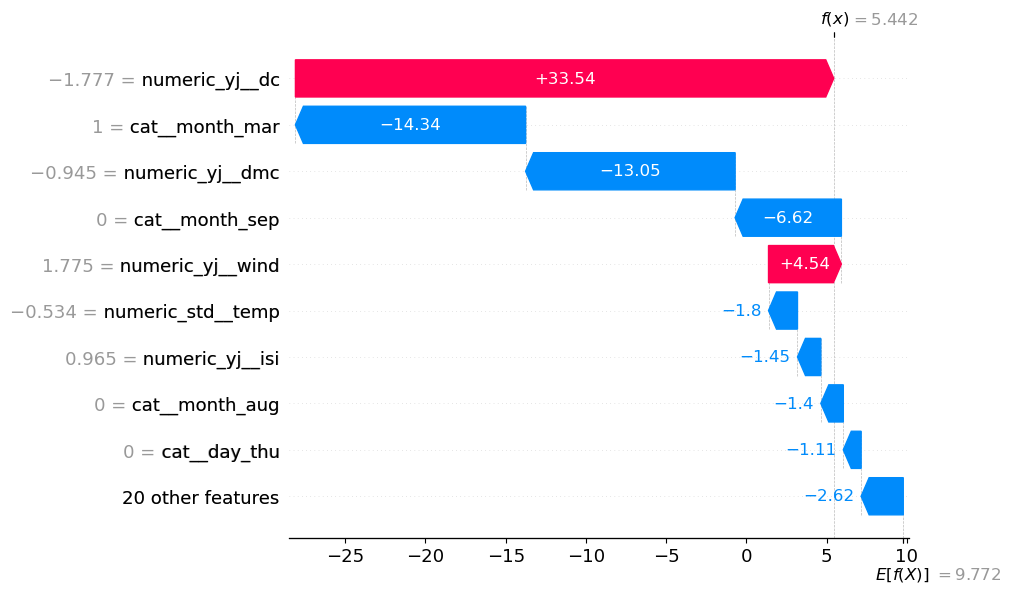

In [1158]:
i = 55  
shap.plots.waterfall(shap_values[i])

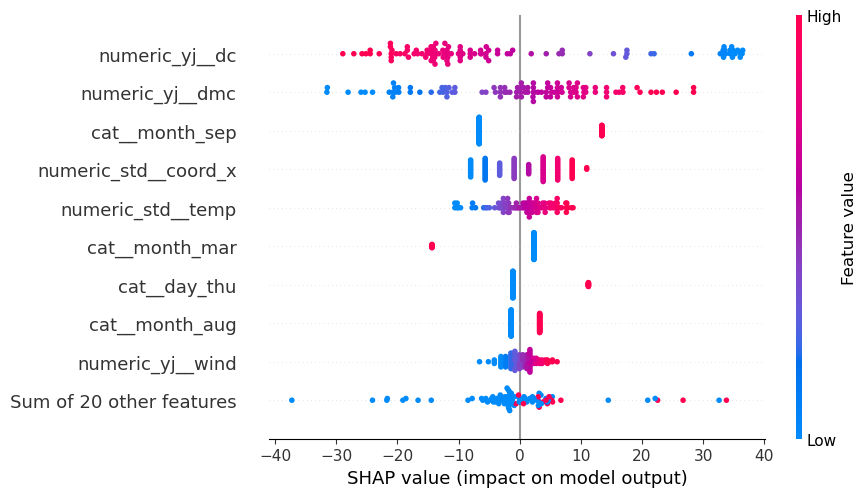

In [1159]:
shap.plots.beeswarm(shap_values)


In [1160]:
shap_importance = np.abs(shap_values.values).mean(axis=0)
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
importance_df = pd.DataFrame({
    'feature': feature_names,
    'mean_abs_shap': shap_importance
}).sort_values(by='mean_abs_shap', ascending=True)
importance_df

,feature,mean_abs_shap
19,cat__month_nov,0.000000
22,cat__day_fri,0.055292
13,cat__month_feb,0.112296
18,cat__month_may,0.219742
25,cat__day_sun,0.229702
1,numeric_std__coord_y,0.298053
14,cat__month_jan,0.327239
15,cat__month_jul,0.330447
4,numeric_yj__ffmc,0.464954
10,cat__month_apr,0.707996


*(Answer here.)*

> The least important feature appears to be ‘month’, while ‘dc’ and ‘dmc’ are the most influential. I’d retrain the model without the less important features, and if the test score improves, it would suggest those features weren’t actually contributing to the model’s performance.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.